In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy as sp

In [3]:
players = pd.read_pickle('players.pkl')
results = pd.read_pickle('results.pkl')
tournaments = pd.read_pickle('tournaments.pkl')

### Подсчет сложности турнира как средняя сложность вопроса

In [4]:
tournament_number_of_questions = {}
tournament_complexity_2019 = {}
tournament_complexity_2019_no_zeros = {}
tournament_complexity_2020 = {}
tournament_complexity_2020_no_zeros = {}
for tournament in tournaments.values():
    questionQty = tournament['questionQty']
    res = 0
    num_of_questions = 0
    if questionQty is not None:
        for complexity, num_of_questions_with_complexity in questionQty.items():
            res += int(complexity) * num_of_questions_with_complexity
            num_of_questions += num_of_questions_with_complexity
    if tournament['dateStart'] >= '2019-01-01' and tournament['dateStart'] < '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2019[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2019[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2019_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
    elif tournament['dateStart'] >= '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2020[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2020[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2020_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
            
print(len(tournament_complexity_2019))
print(len(tournament_complexity_2019_no_zeros))
print(len(tournament_complexity_2020))
print(len(tournament_complexity_2020_no_zeros))
print(len(tournament_number_of_questions))

tournament_complexity = tournament_complexity_2019
tournament_complexity.update(tournament_complexity_2020)

687
687
422
422
1109


### Подсчет сложности вопросов как процента правильных ответов и оценка рейтинга игроков 

In [5]:
tournament_ids_with_mask_number_of_questions_inconsistency = set()

player_real_rating_by_the_beginning_of_2019 = {}
player_real_rating_by_the_end_of_2019 = {}
player_estimated_rating_increase_in_2019 = {}

player_real_rating_by_the_beginning_of_2020 = {}
player_real_rating_by_the_end_of_2020 = {}
player_estimated_rating_increase_in_2020 = {}

team_player_ids_2019 = {}
team_player_ids_2020 = {}
percent_answered_by_team = {}

team_id = 1
for tournament_id, tournament_result in results.items():
    if tournament_id in tournament_number_of_questions:
        tournament_masks = []
        for team_result in tournament_result:
            if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                team_mask = []
                for i in range(tournament_number_of_questions[tournament_id]):
                    question_result = team_result['mask'][i]
                    if question_result == '0' or question_result == '1':
                        team_mask.append(float(question_result))
                    else:
                        team_mask.append(0.5)
                tournament_masks.append(team_mask)
        if len(tournament_masks) == 0:
            tournament_ids_with_mask_number_of_questions_inconsistency.add(tournament_id)
        else:
            tournament_question_complexity = 1 - np.mean(np.array(tournament_masks), axis=0)
            for team_result in tournament_result:
                if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                    team_mask = []
                    for i in range(tournament_number_of_questions[tournament_id]):
                        question_result = team_result['mask'][i]
                        if question_result == '0' or question_result == '1':
                            team_mask.append(float(question_result))
                        else:
                            team_mask.append(0.5)
                    percent_answered_by_team[team_id] = np.sum(np.array(team_mask)) / len(team_mask)
                    estimated_rating_increase = tournament_complexity[tournament_id] * np.dot(tournament_question_complexity, team_mask)
                    player_ids = []
                    for player in team_result['teamMembers']:
                        player_id = player['player']['id']
                        player_rating = player['rating']
                        player_ids.append(player_id)
                        if tournaments[tournament_id]['dateStart'] < '2020-01-01':
                            if player_id not in player_real_rating_by_the_beginning_of_2019:
                                player_real_rating_by_the_beginning_of_2019[player_id] = player_rating
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] += estimated_rating_increase
                        else:
                            if player_id not in player_real_rating_by_the_beginning_of_2020:
                                player_real_rating_by_the_beginning_of_2020[player_id] = player_rating
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] += estimated_rating_increase
                    if tournaments[tournament_id]['dateStart'] < '2020-01-01':
                        team_player_ids_2019[team_id] = player_ids
                    else:
                        team_player_ids_2020[team_id] = player_ids
                    team_id += 1
                        
print(len(tournament_ids_with_mask_number_of_questions_inconsistency))

262


### Baseline-модель, обучающая рейтинг-лист игроков

57429
57429
30409
30409
0.3891916126362257


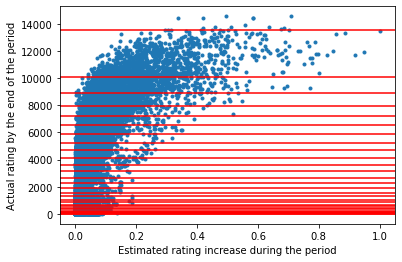

In [6]:
def get_category_upper_borders(array, num_of_categories):
    array_sorted = np.sort(array)
    category_size = int(len(array_sorted) / num_of_categories)
    category_upper_borders = []
    for i in range(num_of_categories):
        category_upper_border_index = (i + 1) * category_size - 1
        category_upper_borders.append(array_sorted[category_upper_border_index])
    return category_upper_borders

def get_category(element, category_upper_borders):
    num_of_categories = len(category_upper_borders)
    for i in range(num_of_categories):
        if element <= category_upper_borders[i]:
            return i
    return num_of_categories - 1

x_train = np.array(list(player_estimated_rating_increase_in_2019.values()))
print(len(x_train))
y_train = np.array(list(player_real_rating_by_the_end_of_2019.values()))
print(len(y_train))
x_train = x_train[y_train != 0]
print(len(x_train))
y_train = y_train[y_train != 0]
print(len(y_train))
x_train = np.interp(x_train, (x_train.min(), x_train.max()), (0, 1))
plt.scatter(x_train, y_train, marker='.')
plt.xlabel("Estimated rating increase during the period")
plt.ylabel("Actual rating by the end of the period")
category_upper_borders = get_category_upper_borders(y_train, 30)
y_train = np.array([get_category(y, category_upper_borders) for y in y_train])
for border in category_upper_borders:
    plt.axhline(y=border, color='red')
    
clf = LogisticRegression(random_state=0).fit(x_train.reshape(-1, 1), y_train)

x_test = np.array(list(player_estimated_rating_increase_in_2020.values()))
x_test = np.interp(x_test, (x_test.min(), x_test.max()), (0, 1))
y_test = np.array(list(player_real_rating_by_the_end_of_2020.values()))
y_test = np.array([get_category(y, category_upper_borders) for y in y_test])

score = clf.score(x_test.reshape(-1, 1), y_test)
print(score)

### Кластеризация по максимальному рейтингу игрока в команде

In [7]:
def e_step(xs, pis, mus, sigmas):
    k = mus.shape[0]
    z = np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ])
    print(mus[0])
    print(sp.stats.multivariate_normal.pdf(xs, mean=mus[0], cov=sigmas[0]))
    ## здесь z_{nk} = p(C_k)p(x_n|C_k)
    z = np.divide( z, np.sum(z, axis=0) ).T
    ## z_{nk} = p(C_k|x_n)
    return z

def m_step(xs, z):
    k = z.shape[1]
    pis = np.sum(z, axis=0) / np.sum(z)
    mus = np.array([np.average(xs, weights=z[:,i], axis=0) for i in range(k)])
    sigmas = np.array([np.cov(xs.T, aweights=z[:,i]) for i in range(k)])
    return pis, mus, sigmas

def loglikelihood(xs, pis, mus, sigmas):
    k = mus.shape[0]
    return np.sum(np.log(np.sum(np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ]), axis=0)))

In [12]:
def normalize(x):
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    return (x - x_min) / (x_max - x_min)

In [9]:
team_results = []
for team_id, player_ids in team_player_ids_2019.items():
    team_player_ratings = []
    for i in range(len(player_ids)):
        if player_ids[i] in player_estimated_rating_increase_in_2019:
            team_player_ratings.append(player_estimated_rating_increase_in_2019[player_ids[i]])
    team_results.append(-np.sort(-np.array(team_player_ratings)))

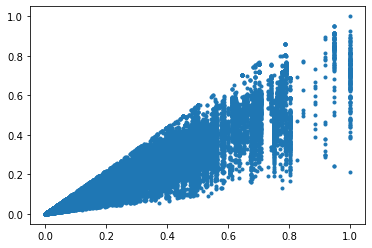

In [16]:
x_train = []
for team_result in team_results:
    x_train.append([team_result[0], np.mean(team_result)])
x_train = normalize(np.array(x_train))
plt.scatter(x_train[:, 0], x_train[:, 1], marker='.')

In [22]:
def em(x, k):
    mus = x[np.random.choice(x.shape[0], size=k, replace=False), : ]
    sigmas = np.array( [ 1 for _ in range(k) ] )
    pis = (1./k) * np.ones(k)
    z = e_step( x, pis, mus, sigmas)

    ## EM-алгоритм
    old_logl, new_logl = -np.inf, -np.inf
    for iIter in range(5000):
        old_logl = new_logl
        z = e_step( x, pis, mus, sigmas)
        print(z)
        new_pis, new_mus, new_sigmas = m_step(x, z)
        pis, mus, sigmas = new_pis, new_mus, new_sigmas
        new_logl = loglikelihood(x, pis, mus, sigmas)
        print("Логарифм правдоподобия на итерации %03d: %.6f" % (iIter, new_logl) )
        if np.abs(new_logl - old_logl) < 0.01:
            break

    print("После %d итераций правдоподобие = %.6f" % (iIter, new_logl) )
    
    if len(x[0, :] == 1):
        plt.scatter(x, np.zeros(len(x)), marker='.')
        for i in range(k):
            t = np.linspace(0, 2*np.pi, 100)
            r = np.sqrt(sigmas[i])
            circle = plt.plot(mus[i] + r*np.cos(t) , r*np.sin(t))
            mu = plt.scatter(mus[i], 0, marker='.', color=circle[0].get_color(), label=f'Cluster: {i}')
        plt.legend()
        plt.xlabel("Maximal player rating in team")
    
    return pis, mus, sigmas

[0.45346341]
[0.39679188 0.39167639 0.38834291 ... 0.36247839 0.36194439 0.36081443]
[0.45346341]
[0.39679188 0.39167639 0.38834291 ... 0.36247839 0.36194439 0.36081443]
[[0.151656   0.14759108 0.14289263 ... 0.14557007 0.14887282 0.13127364]
 [0.14447569 0.14703542 0.14684864 ... 0.14715012 0.12891557 0.14257336]
 [0.14346648 0.14690195 0.14733869 ... 0.14730898 0.12635942 0.14413156]
 ...
 [0.13823029 0.14601544 0.1496515  ... 0.14791186 0.11392522 0.15213347]
 [0.13814386 0.14599821 0.1496866  ... 0.14791885 0.11373081 0.15226458]
 [0.1379626  0.14596181 0.14975991 ... 0.1479332  0.11332414 0.15253947]]
Логарифм правдоподобия на итерации 000: 18630.607072
[0.1980694]
[0.3797929  1.92936868 2.01936223 ... 1.31962854 1.29861828 1.25446617]
[[0.15994937 0.14833702 0.13845735 ... 0.14386543 0.17118524 0.11841542]
 [0.14168991 0.14669765 0.1482364  ... 0.1476235  0.12176984 0.14686666]
 [0.14027688 0.14640574 0.14879846 ... 0.14772615 0.11863197 0.1490072 ]
 ...
 [0.13766912 0.14583528 0

[0.33506005]
[0.71847065 2.6070459  2.09100043 ... 0.15434563 0.14492212 0.12672361]
[[2.16308092e-01 1.48325161e-02 9.41283285e-10 ... 1.45718859e-04
  7.68713673e-01 6.64034209e-51]
 [2.40877399e-01 2.71057149e-01 1.12150001e-01 ... 2.51979560e-01
  1.23934808e-01 8.53653607e-10]
 [1.61663833e-01 2.28951676e-01 2.48864292e-01 ... 2.80559013e-01
  7.98415819e-02 8.98661035e-07]
 ...
 [4.88229148e-03 1.26782060e-02 2.36415980e-02 ... 1.75626108e-02
  4.49610277e-03 5.58665021e-01]
 [4.94311303e-03 1.28622547e-02 2.27699491e-02 ... 1.75378413e-02
  4.65188303e-03 5.58789125e-01]
 [5.19950457e-03 1.35760478e-02 2.14166813e-02 ... 1.78739871e-02
  5.12681773e-03 5.56135809e-01]]
Логарифм правдоподобия на итерации 016: 44570.599994
[0.33705879]
[0.71277408 2.61528112 2.07067736 ... 0.13558182 0.12696056 0.11038224]
[[2.16146529e-01 1.47958963e-02 3.97583355e-11 ... 7.79240620e-05
  7.68979650e-01 2.50170038e-59]
 [2.48444737e-01 2.76648589e-01 9.64931445e-02 ... 2.54174625e-01
  1.24238255

[0.60114263 2.62580972 1.80892032 ... 0.03168057 0.02879135 0.02348902]
[[2.09178168e-01 1.39085667e-02 2.49047150e-22 ... 2.18967714e-06
  7.76911076e-01 0.00000000e+00]
 [2.99668261e-01 3.21337004e-01 1.03899742e-02 ... 2.59743558e-01
  1.08861202e-01 5.34934115e-70]
 [1.84203864e-01 2.64561966e-01 1.15648766e-01 ... 3.63497337e-01
  7.20856512e-02 6.85101920e-49]
 ...
 [5.53278818e-04 2.54873368e-03 5.46518362e-03 ... 4.89082641e-03
  1.36662298e-03 9.11015152e-01]
 [5.33754367e-04 2.49468654e-03 4.66879055e-03 ... 4.65766604e-03
  1.38640270e-03 9.21701280e-01]
 [5.91405717e-04 2.84806412e-03 3.94048600e-03 ... 5.00335275e-03
  1.71055147e-03 9.30390363e-01]]
Логарифм правдоподобия на итерации 027: 49952.956801
[0.35156103]
[0.60066773 2.6135679  1.78684625 ... 0.0293178  0.026606   0.02164036]
[[2.10680917e-01 1.33763878e-02 1.42806401e-22 ... 1.62508696e-06
  7.75941070e-01 0.00000000e+00]
 [2.99199886e-01 3.22744444e-01 9.85015203e-03 ... 2.62245114e-01
  1.05960404e-01 4.400502

[0.36525353]
[0.67836353 2.33728136 1.4595593  ... 0.01211221 0.01083741 0.00855439]
[[2.56861449e-001 7.69845479e-003 9.00859699e-031 ... 2.00939495e-007
  7.35439896e-001 0.00000000e+000]
 [2.78442463e-001 3.31536881e-001 1.65836335e-003 ... 3.12892293e-001
  7.54699993e-002 3.38082194e-213]
 [1.60685174e-001 2.73665837e-001 5.28961657e-002 ... 4.63446994e-001
  4.93058299e-002 2.55701057e-150]
 ...
 [2.09550265e-004 1.29230320e-003 2.29523573e-003 ... 1.82439351e-003
  6.40009017e-004 8.44941877e-001]
 [1.62013048e-004 1.01272623e-003 1.48543345e-003 ... 1.36433403e-003
  5.25692881e-004 8.92081507e-001]
 [1.53112062e-004 9.83806030e-004 9.43609379e-004 ... 1.19605559e-003
  5.65365953e-004 9.22520879e-001]]
Логарифм правдоподобия на итерации 043: 51441.236977
[0.36614094]
[0.68519327 2.31684026 1.43855559 ... 0.01145964 0.01024502 0.00807261]
[[2.60360775e-001 7.34757248e-003 3.64986183e-031 ... 1.85693041e-007
  7.32291467e-001 0.00000000e+000]
 [2.76166515e-001 3.31532226e-001 1.

[0.37581461]
[0.74672791 2.07363867 1.19171102 ... 0.00529806 0.00467945 0.00359372]
[[2.94273151e-001 4.08801419e-003 1.98373910e-032 ... 8.38937153e-008
  7.01638751e-001 0.00000000e+000]
 [2.49295901e-001 3.31938863e-001 7.61058502e-004 ... 3.59338822e-001
  5.86653559e-002 0.00000000e+000]
 [1.31217193e-001 2.75263714e-001 3.23015333e-002 ... 5.24402127e-001
  3.68154330e-002 1.49347063e-296]
 ...
 [1.36396975e-004 1.55363587e-003 5.90176381e-003 ... 1.71392923e-003
  5.89301037e-004 6.59428533e-001]
 [7.88457867e-005 9.15227098e-004 2.92364901e-003 ... 9.54272445e-004
  3.65359612e-004 8.18650329e-001]
 [5.21195091e-005 6.28866907e-004 1.36412670e-003 ... 5.79693853e-004
  2.80437245e-004 9.05650590e-001]]
Логарифм правдоподобия на итерации 055: 52080.741787
[0.3766524]
[0.75054531 2.0501511  1.16834643 ... 0.00486286 0.00428908 0.00328421]
[[2.96751728e-001 3.83836264e-003 2.45000234e-032 ... 7.97033433e-008
  6.99409830e-001 0.00000000e+000]
 [2.46715970e-001 3.32259749e-001 7.4

[0.38637078]
[7.76243961e-01 1.73693709e+00 8.75206551e-01 ... 1.35870401e-03
 1.17343897e-03 8.59310666e-04]
[[3.19961206e-01 1.38251339e-03 4.46360489e-30 ... 6.52159322e-08
  6.78656215e-01 0.00000000e+00]
 [2.11133444e-01 3.43791992e-01 7.98540059e-04 ... 4.00581265e-01
  4.36947585e-02 0.00000000e+00]
 [9.50952279e-02 2.85618091e-01 2.80100765e-02 ... 5.65630877e-01
  2.56457277e-02 0.00000000e+00]
 ...
 [5.08525547e-05 1.66279700e-03 2.62833341e-02 ... 2.06373067e-03
  4.66052214e-04 3.78810781e-01]
 [2.58368298e-05 8.69445983e-04 1.22963246e-02 ... 1.02484896e-03
  2.58468672e-04 7.04553655e-01]
 [1.11285837e-05 3.97315939e-04 4.36146861e-03 ... 4.18427160e-04
  1.34190717e-04 8.98458369e-01]]
Логарифм правдоподобия на итерации 069: 52485.327955
[0.3870169]
[7.76821653e-01 1.71320438e+00 8.54640601e-01 ... 1.22333435e-03
 1.05469135e-03 7.69507344e-04]
[[3.21181076e-01 1.26104902e-03 6.87864864e-30 ... 6.63363916e-08
  6.77557809e-01 0.00000000e+00]
 [2.08327510e-01 3.45231514e-

[0.39444734]
[7.77451604e-01 1.41742812e+00 6.19569969e-01 ... 3.03971349e-04
 2.56121609e-04 1.77989212e-04]
[[3.34302138e-01 3.51231397e-04 5.35738569e-28 ... 1.09990660e-07
  6.65346521e-01 0.00000000e+00]
 [1.72231478e-01 3.70232992e-01 9.08055214e-04 ... 4.25439086e-01
  3.11883897e-02 0.00000000e+00]
 [6.63014943e-02 3.09733374e-01 2.63964530e-02 ... 5.80468535e-01
  1.71001440e-02 0.00000000e+00]
 ...
 [1.30579193e-05 1.19438567e-03 6.57952279e-02 ... 2.57414653e-03
  2.60207878e-04 1.54875321e-01]
 [7.29397523e-06 6.90821367e-04 3.59975788e-02 ... 1.44435432e-03
  1.61616181e-04 5.49530658e-01]
 [2.15338090e-06 2.19089628e-04 9.99174568e-03 ... 4.28376954e-04
  5.98152321e-05 8.91782656e-01]]
Логарифм правдоподобия на итерации 084: 52729.301920
[0.39486954]
[7.77468697e-01 1.39979349e+00 6.06820262e-01 ... 2.78498475e-04
 2.34323844e-04 1.62348833e-04]
[[3.35140973e-01 3.24456362e-04 6.41887347e-28 ... 1.15054764e-07
  6.64534455e-01 0.00000000e+00]
 [1.70031308e-01 3.72166799e

Логарифм правдоподобия на итерации 098: 52834.806401
[0.39961244]
[7.85005305e-01 1.20593267e+00 4.76554141e-01 ... 1.04633772e-04
 8.66665799e-05 5.80811914e-05]
[[3.48635551e-01 1.52492988e-04 2.27217505e-27 ... 2.01248860e-07
  6.51211754e-01 0.00000000e+00]
 [1.45861000e-01 3.97399451e-01 8.34926456e-04 ... 4.33676891e-01
  2.22277310e-02 0.00000000e+00]
 [5.04376992e-02 3.31994227e-01 2.33548911e-02 ... 5.82752293e-01
  1.14608894e-02 0.00000000e+00]
 ...
 [4.44864972e-06 8.28697615e-04 9.38892986e-02 ... 3.16306920e-03
  1.23813294e-04 4.92130755e-02]
 [3.01000611e-06 5.82694237e-04 6.43592143e-02 ... 2.20160664e-03
  9.41471819e-05 3.75388493e-01]
 [6.73182138e-07 1.41025750e-04 1.45450038e-02 ... 5.20372057e-04
  2.70012202e-05 8.84029017e-01]]
Логарифм правдоподобия на итерации 099: 52839.653610
[0.39988316]
[7.86143518e-01 1.19550155e+00 4.70085391e-01 ... 9.92814031e-05
 8.21659470e-05 5.49694589e-05]
[[3.49769464e-01 1.48372690e-04 2.32458966e-27 ... 2.07437614e-07
  6.5008

[0.40322497]
[8.11211354e-01 1.07829425e+00 4.01743589e-01 ... 5.64279105e-05
 4.63053364e-05 3.04263046e-05]
[[3.69217583e-01 1.36995207e-04 1.68466579e-27 ... 2.63165935e-07
  6.30645158e-01 0.00000000e+00]
 [1.30520613e-01 4.19903305e-01 6.71832150e-04 ... 4.33072198e-01
  1.58320512e-02 0.00000000e+00]
 [4.22461762e-02 3.45584138e-01 1.95327054e-02 ... 5.84970878e-01
  7.66610284e-03 0.00000000e+00]
 ...
 [2.27111261e-06 6.98021755e-04 1.06293724e-01 ... 3.82625698e-03
  5.57667300e-05 1.45874455e-02]
 [1.80668256e-06 5.79908129e-04 8.71046537e-02 ... 3.18014940e-03
  4.99946542e-05 2.29557108e-01]
 [3.45453583e-07 1.21244683e-04 1.74348410e-02 ... 6.64183415e-04
  1.23315780e-05 8.76146414e-01]]
Логарифм правдоподобия на итерации 115: 52890.687110
[0.40340978]
[8.13300032e-01 1.07256024e+00 3.98626914e-01 ... 5.50089614e-05
 4.51247055e-05 2.96279791e-05]
[[3.70638059e-01 1.38552078e-04 1.59127859e-27 ... 2.63414363e-07
  6.29223125e-01 0.00000000e+00]
 [1.29860198e-01 4.21146770e

Логарифм правдоподобия на итерации 126: 52909.181751
[0.40522303]
[8.38372284e-01 1.02115999e+00 3.71852908e-01 ... 4.46128493e-05
 3.64951265e-05 2.38216653e-05]
[[3.86770585e-01 1.68502881e-04 6.82941272e-28 ... 2.35604038e-07
  6.13060677e-01 0.00000000e+00]
 [1.24139573e-01 4.34517055e-01 5.39582192e-04 ... 4.28295102e-01
  1.25086879e-02 0.00000000e+00]
 [3.89695456e-02 3.51003691e-01 1.66212785e-02 ... 5.87623907e-01
  5.78157711e-03 0.00000000e+00]
 ...
 [1.73475630e-06 6.78357523e-04 1.09931313e-01 ... 4.33326982e-03
  3.20154270e-05 7.08346700e-03]
 [1.47656745e-06 6.05126562e-04 9.69032615e-02 ... 3.87688630e-03
  3.06665918e-05 1.65063132e-01]
 [2.69462938e-07 1.21657255e-04 1.87178618e-02 ... 7.82715210e-04
  7.19796937e-06 8.71407291e-01]]
Логарифм правдоподобия на итерации 127: 52910.530063
[0.40537085]
[8.40797560e-01 1.01737089e+00 3.69972275e-01 ... 4.40076183e-05
 3.59941416e-05 2.34865524e-05]
[[3.88263966e-01 1.72243744e-04 6.21260951e-28 ... 2.30671314e-07
  6.1156

[8.76217946e-01 9.74964523e-01 3.50027607e-01 ... 3.87914183e-05
 3.16889029e-05 2.06241169e-05]
[[4.09103880e-01 2.36703375e-04 1.26317348e-28 ... 1.40588886e-07
  5.90659276e-01 0.00000000e+00]
 [1.19467648e-01 4.54681707e-01 3.87204334e-04 ... 4.15901801e-01
  9.56163938e-03 0.00000000e+00]
 [3.65232444e-02 3.55969248e-01 1.31481303e-02 ... 5.90183488e-01
  4.17588883e-03 0.00000000e+00]
 ...
 [1.46521844e-06 6.57736990e-04 1.11873291e-01 ... 4.96373606e-03
  1.71090160e-05 3.80905292e-03]
 [1.30310508e-06 6.14362721e-04 1.03243857e-01 ... 4.65345588e-03
  1.70583858e-05 1.22106009e-01]
 [2.33529904e-07 1.21848651e-04 1.96574036e-02 ... 9.28031052e-04
  3.90033991e-06 8.67263427e-01]]
Логарифм правдоподобия на итерации 142: 52927.723541
[0.40734642]
[8.78822501e-01 9.72524117e-01 3.48948969e-01 ... 3.85816080e-05
 3.15165789e-05 2.05107144e-05]
[[4.10569712e-01 2.41817590e-04 1.10658934e-28 ... 1.33679167e-07
  5.89188336e-01 0.00000000e+00]
 [1.19238937e-01 4.56220696e-01 3.7782884

[9.05220735e-01 9.50667270e-01 3.39622102e-01 ... 3.71070450e-05
 3.03105233e-05 1.97240547e-05]
[[4.24909322e-01 2.90808629e-04 2.54757018e-29 ... 7.10589471e-08
  5.74799798e-01 0.00000000e+00]
 [1.17279221e-01 4.73761533e-01 2.89870813e-04 ... 4.00653066e-01
  8.01630905e-03 0.00000000e+00]
 [3.53057625e-02 3.60355993e-01 1.07652472e-02 ... 5.90208595e-01
  3.36440197e-03 0.00000000e+00]
 ...
 [1.38087518e-06 6.09160290e-04 1.12459868e-01 ... 5.39832662e-03
  1.13577521e-05 2.82122218e-03]
 [1.25000468e-06 5.78581047e-04 1.05587701e-01 ... 5.14892403e-03
  1.14876310e-05 1.04985012e-01]
 [2.23610628e-07 1.14314231e-04 2.00390999e-02 ... 1.02381883e-03
  2.60336738e-06 8.65259849e-01]]
Логарифм правдоподобия на итерации 153: 52939.556488
[0.40860981]
[9.07892665e-01 9.48653185e-01 3.38786960e-01 ... 3.69997889e-05
 3.02232466e-05 1.96677543e-05]
[[4.26306360e-01 2.95109770e-04 2.16509819e-29 ... 6.57699496e-08
  5.73398464e-01 0.00000000e+00]
 [1.17105289e-01 4.75773107e-01 2.8164950

Логарифм правдоподобия на итерации 167: 52958.144908
[0.41019863]
[9.45957692e-01 9.20064134e-01 3.26880555e-01 ... 3.53717056e-05
 2.88958822e-05 1.88078959e-05]
[[4.45024058e-01 3.25349974e-04 1.49354206e-30 ... 1.56194446e-08
  5.54650576e-01 0.00000000e+00]
 [1.14620225e-01 5.10920082e-01 1.77046004e-04 ... 3.67784774e-01
  6.49787322e-03 0.00000000e+00]
 [3.37836885e-02 3.70144851e-01 7.70454232e-03 ... 5.85775357e-01
  2.59156100e-03 0.00000000e+00]
 ...
 [1.29353535e-06 4.72197658e-04 1.12712686e-01 ... 5.87186560e-03
  6.94069221e-06 2.12437643e-03]
 [1.18864074e-06 4.52595387e-04 1.07220784e-01 ... 5.66477655e-03
  7.09608755e-06 9.07543403e-02]
 [2.13130932e-07 8.85150901e-05 2.02992769e-02 ... 1.11989232e-03
  1.59754130e-06 8.63437973e-01]]
Логарифм правдоподобия на итерации 168: 52959.779358
[0.41031871]
[9.48730009e-01 9.17795215e-01 3.25904199e-01 ... 3.52003142e-05
 2.87553123e-05 1.87156633e-05]
[[4.46296490e-01 3.24456193e-04 1.19103953e-30 ... 1.36626945e-08
  5.5337

Логарифм правдоподобия на итерации 180: 52985.437896
[0.41193746]
[9.82552281e-01 8.83685118e-01 3.10400267e-01 ... 3.16085337e-05
 2.57951623e-05 1.67535133e-05]
[[4.60785317e-01 2.70031812e-04 4.42951318e-32 ... 1.68263103e-09
  5.38944650e-01 0.00000000e+00]
 [1.11028705e-01 5.60829907e-01 9.71961959e-05 ... 3.22480001e-01
  5.56419096e-03 0.00000000e+00]
 [3.19406016e-02 3.85488099e-01 5.17230578e-03 ... 5.75266154e-01
  2.13283902e-03 0.00000000e+00]
 ...
 [1.13659898e-06 2.98275985e-04 1.12650577e-01 ... 6.00455971e-03
  4.77574257e-06 1.76116973e-03]
 [1.05297704e-06 2.85118023e-04 1.07852523e-01 ... 5.80353535e-03
  4.91229025e-06 8.22971588e-02]
 [1.89105624e-07 5.45698270e-05 2.03576290e-02 ... 1.13311860e-03
  1.10275062e-06 8.62357087e-01]]
Логарифм правдоподобия на итерации 181: 52988.276102
[0.41209295]
[9.85398709e-01 8.80014049e-01 3.08655471e-01 ... 3.11358215e-05
 2.54048115e-05 1.64937099e-05]
[[4.61917787e-01 2.61806881e-04 3.16182700e-32 ... 1.34179586e-09
  5.3782

[0.41478754]
[1.02313434e+00 8.05422935e-01 2.71886614e-01 ... 2.08549742e-05
 1.69220373e-05 1.08579657e-05]
[[4.75735248e-01 1.14412733e-04 4.34210566e-35 ... 1.36355645e-11
  5.24150339e-01 0.00000000e+00]
 [1.01934652e-01 6.54061536e-01 3.00302460e-05 ... 2.39217127e-01
  4.75665510e-03 0.00000000e+00]
 [2.80898005e-02 4.19086337e-01 2.42372024e-03 ... 5.48633319e-01
  1.76682278e-03 0.00000000e+00]
 ...
 [7.30075561e-07 1.04706812e-04 1.12319730e-01 ... 5.31185019e-03
  3.21904616e-06 1.43462750e-03]
 [6.79082632e-07 9.82359362e-05 1.07943354e-01 ... 5.08509520e-03
  3.33252245e-06 7.38443750e-02]
 [1.21287167e-07 1.78125097e-05 2.02158036e-02 ... 9.57917121e-04
  7.47867809e-07 8.61422931e-01]]
Логарифм правдоподобия на итерации 196: 53056.695711
[0.41502188]
[1.02540352e+00 7.98010344e-01 2.68181661e-01 ... 1.98890376e-05
 1.61269680e-05 1.03324768e-05]
[[4.76501468e-01 1.03982454e-04 2.22291245e-35 ... 8.53030868e-12
  5.23394550e-01 0.00000000e+00]
 [1.01013995e-01 6.62098768e

[1.03555568e+00 6.64505857e-01 2.02576925e-01 ... 7.00464362e-06
 5.58886762e-06 3.46045809e-06]
[[4.80351984e-01 1.32298984e-05 4.66422416e-42 ... 3.18649992e-16
  5.19634786e-01 0.00000000e+00]
 [8.31803543e-02 7.96326858e-01 1.97459735e-06 ... 1.16411353e-01
  4.07945945e-03 0.00000000e+00]
 [2.19793248e-02 4.94166365e-01 4.45852012e-04 ... 4.81842479e-01
  1.56597943e-03 0.00000000e+00]
 ...
 [2.35777876e-07 1.50415502e-05 1.10706172e-01 ... 2.90914233e-03
  2.20482446e-06 1.10613478e-03]
 [2.18278103e-07 1.35286892e-05 1.06065541e-01 ... 2.68390308e-03
  2.30296332e-06 6.42339826e-02]
 [3.80860066e-08 2.21127414e-06 1.93912619e-02 ... 4.59772535e-04
  5.19701079e-07 8.60731933e-01]]
Логарифм правдоподобия на итерации 211: 53228.151758
[0.41883464]
[1.03380739e+00 6.53868966e-01 1.97500614e-01 ... 6.34005423e-06
 5.05058024e-06 3.11665544e-06]
[[4.79926759e-01 1.08313035e-05 8.33708328e-43 ... 1.08958450e-16
  5.20062409e-01 0.00000000e+00]
 [8.16496229e-02 8.06542186e-01 1.4742775

[9.75121086e-01 5.54417268e-01 1.50611782e-01 ... 1.99961050e-06
 1.56273879e-06 9.25990377e-07]
[[4.64910398e-01 7.76888441e-07 4.81496936e-56 ... 1.53847296e-24
  5.35088825e-01 0.00000000e+00]
 [6.54391111e-02 9.05299150e-01 8.16372104e-09 ... 2.56692630e-02
  3.59246770e-03 0.00000000e+00]
 [1.84894521e-02 6.55229946e-01 1.53677625e-05 ... 3.24634898e-01
  1.63033574e-03 0.00000000e+00]
 ...
 [6.44811119e-08 2.77669864e-06 1.03996882e-01 ... 7.66510140e-04
  1.76616706e-06 7.24568921e-04]
 [5.94653633e-08 2.41015504e-06 9.81109804e-02 ... 6.57722547e-04
  1.87270495e-06 5.09500989e-02]
 [1.01944286e-08 3.61493206e-07 1.70515047e-02 ... 9.51603219e-05
  4.32202115e-07 8.59579459e-01]]
Логарифм правдоподобия на итерации 225: 53483.813632
[0.4200635]
[9.69106131e-01 5.51998083e-01 1.49323784e-01 ... 1.90824497e-06
 1.49006257e-06 8.81327460e-07]
[[4.63350425e-01 6.67175217e-07 3.83081067e-57 ... 3.48013157e-25
  5.36648908e-01 0.00000000e+00]
 [6.48442971e-02 9.09035928e-01 5.28159895

[[4.47890117e-01 2.99180104e-07 5.54765055e-68 ... 1.51537896e-31
  5.52109583e-01 0.00000000e+00]
 [6.74434257e-02 9.23446201e-01 6.44353053e-11 ... 5.43801281e-03
  3.67236086e-03 0.00000000e+00]
 [2.09634367e-02 8.06008345e-01 6.98084111e-07 ... 1.71196356e-01
  1.83116420e-03 0.00000000e+00]
 ...
 [6.94702970e-08 4.60434173e-06 1.01235596e-01 ... 3.20754863e-04
  1.93886033e-06 3.42968122e-04]
 [6.51692705e-08 4.08184318e-06 9.49433774e-02 ... 2.62839289e-04
  2.09316400e-06 3.35478600e-02]
 [1.17043304e-08 6.46743324e-07 1.63479916e-02 ... 3.46825258e-05
  5.07107972e-07 8.54465936e-01]]
Логарифм правдоподобия на итерации 240: 53615.446621
[0.41738371]
[9.06403562e-01 5.96302485e-01 1.64606996e-01 ... 2.33746751e-06
 1.82841838e-06 1.08543046e-06]
[[4.47386717e-01 3.01914250e-07 1.93594042e-68 ... 8.64335710e-32
  5.52612981e-01 0.00000000e+00]
 [6.81064267e-02 9.23098758e-01 5.30141421e-11 ... 5.10143720e-03
  3.69337793e-03 0.00000000e+00]
 [2.12521622e-02 8.11291751e-01 6.12549

Логарифм правдоподобия на итерации 250: 53648.957744
[0.4156107]
[8.94419810e-01 6.52268564e-01 1.88142873e-01 ... 3.73768107e-06
 2.94429153e-06 1.77405628e-06]
[[4.45350400e-01 3.87106564e-07 7.45647489e-72 ... 3.20956279e-33
  5.54649213e-01 0.00000000e+00]
 [7.51956798e-02 9.17597887e-01 1.17775209e-11 ... 3.30655592e-03
  3.89987745e-03 0.00000000e+00]
 [2.41696795e-02 8.44972113e-01 2.18619464e-07 ... 1.28920461e-01
  1.93752828e-03 0.00000000e+00]
 ...
 [1.14076644e-07 9.95364379e-06 1.04987437e-01 ... 3.24472686e-04
  2.16805188e-06 1.94010026e-04]
 [1.08492296e-07 9.03358859e-06 9.88052581e-02 ... 2.65675727e-04
  2.35785968e-06 2.43063282e-02]
 [2.04891460e-08 1.53671612e-06 1.74660375e-02 ... 3.57084736e-05
  5.92609235e-07 8.49341108e-01]]
Логарифм правдоподобия на итерации 251: 53651.401668
[0.41546514]
[8.93922282e-01 6.57383086e-01 1.90385779e-01 ... 3.90304919e-06
 3.07659509e-06 1.85637996e-06]
[[4.45357892e-01 3.99874923e-07 4.00233094e-72 ... 2.73807472e-33
  5.54641

[8.93281873e-01 7.13895170e-01 2.16172316e-01 ... 6.29741561e-06
 5.00106468e-06 3.06559795e-06]
[[4.47295871e-01 6.36587435e-07 1.76211037e-75 ... 1.69982923e-33
  5.52703493e-01 0.00000000e+00]
 [8.36885721e-02 9.09648385e-01 2.22867622e-12 ... 2.58378587e-03
  4.07925686e-03 0.00000000e+00]
 [2.75299283e-02 8.64022829e-01 6.81464305e-08 ... 1.06456351e-01
  1.99082287e-03 0.00000000e+00]
 ...
 [1.87888150e-07 2.15094804e-05 1.10861480e-01 ... 4.44367296e-04
  2.30486311e-06 1.00227190e-04]
 [1.80656479e-07 1.99521132e-05 1.04644734e-01 ... 3.68536485e-04
  2.51605497e-06 1.66625753e-02]
 [3.61814487e-08 3.68429584e-06 1.92487853e-02 ... 5.27344466e-05
  6.60462778e-07 8.42840311e-01]]
Логарифм правдоподобия на итерации 266: 53678.721772
[0.41392545]
[8.93523569e-01 7.16869374e-01 2.17584826e-01 ... 6.45908465e-06
 5.13151330e-06 3.14824089e-06]
[[4.47510714e-01 6.57361371e-07 1.04028494e-75 ... 1.79140741e-33
  5.52488628e-01 0.00000000e+00]
 [8.41165677e-02 9.09232648e-01 2.0055355

[0.41333779]
[8.98371472e-01 7.44770350e-01 2.31218649e-01 ... 8.24186606e-06
 6.57359055e-06 4.06664695e-06]
[[4.50609867e-01 9.76408677e-07 9.41166944e-79 ... 6.39562934e-33
  5.49389156e-01 0.00000000e+00]
 [8.82599458e-02 9.05140213e-01 4.95950064e-13 ... 2.48980792e-03
  4.11003370e-03 0.00000000e+00]
 [2.92424195e-02 8.70368865e-01 2.38868580e-08 ... 9.84161205e-02
  1.97257155e-03 0.00000000e+00]
 ...
 [2.40887240e-07 3.49215511e-05 1.15504101e-01 ... 6.61103422e-04
  2.26884497e-06 5.99176899e-05]
 [2.32612536e-07 3.28055267e-05 1.09012704e-01 ... 5.57355968e-04
  2.47701582e-06 1.23829327e-02]
 [4.86647434e-08 6.44219482e-06 2.07118352e-02 ... 8.55177076e-05
  6.73214265e-07 8.37490904e-01]]
Логарифм правдоподобия на итерации 280: 53696.916737
[0.41331335]
[8.98838507e-01 7.46190652e-01 2.31939227e-01 ... 8.35026845e-06
 6.66148233e-06 4.12289948e-06]
[[4.50858297e-01 1.00500882e-06 5.37335345e-79 ... 7.30210347e-33
  5.49140698e-01 0.00000000e+00]
 [8.84803618e-02 9.04917594e

[9.05047444e-01 7.56893498e-01 2.37614606e-01 ... 9.30456290e-06
 7.43638827e-06 4.62043205e-06]
[[4.53788668e-01 1.40148978e-06 4.47169387e-82 ... 4.58994121e-32
  5.46209930e-01 0.00000000e+00]
 [9.02361046e-02 9.03086777e-01 1.09197388e-13 ... 2.60347168e-03
  4.07364715e-03 0.00000000e+00]
 [2.98572810e-02 8.72621910e-01 8.37160270e-09 ... 9.55932547e-02
  1.92754551e-03 0.00000000e+00]
 ...
 [2.66607630e-07 4.86229462e-05 1.19164989e-01 ... 9.87233057e-04
  2.16499430e-06 3.89881735e-05]
 [2.57658324e-07 4.60364241e-05 1.12242473e-01 ... 8.46123092e-04
  2.36026392e-06 9.64793026e-03]
 [5.57941480e-08 9.49925839e-06 2.18994768e-02 ... 1.39001828e-04
  6.60823706e-07 8.32857788e-01]]
Логарифм правдоподобия на итерации 293: 53712.296513
[0.4131966]
[9.05602659e-01 7.57322864e-01 2.37867889e-01 ... 9.35580687e-06
 7.47807833e-06 4.64730511e-06]
[[4.54024141e-01 1.43943134e-06 2.39086993e-82 ... 5.43842845e-32
  5.45974419e-01 0.00000000e+00]
 [9.03165761e-02 9.02996352e-01 9.65213897

[0.4133848]
[9.13719829e-01 7.57536828e-01 2.38613782e-01 ... 9.66686815e-06
 7.73204642e-06 4.81220009e-06]
[[4.57090906e-01 2.06744587e-06 1.82162520e-86 ... 6.92610504e-31
  5.42907026e-01 0.00000000e+00]
 [9.05982107e-02 9.02520927e-01 1.49718687e-14 ... 2.88118045e-03
  3.99968147e-03 0.00000000e+00]
 [2.97379292e-02 8.73264821e-01 2.12743474e-09 ... 9.51323671e-02
  1.86488066e-03 0.00000000e+00]
 ...
 [2.70219402e-07 6.54924591e-05 1.22914822e-01 ... 1.58723046e-03
  2.01792087e-06 2.40874807e-05]
 [2.60694307e-07 6.23834416e-05 1.15289652e-01 ... 1.38663753e-03
  2.19351374e-06 7.28285734e-03]
 [5.85537576e-08 1.35754551e-05 2.31515896e-02 ... 2.47192178e-04
  6.35418983e-07 8.27491842e-01]]
Логарифм правдоподобия на итерации 308: 53730.676298
[0.41340753]
[9.14316534e-01 7.57195208e-01 2.38493750e-01 ... 9.66299227e-06
 7.72899856e-06 4.81037392e-06]
[[4.57291305e-01 2.12011799e-06 8.73101751e-87 ... 8.38213831e-31
  5.42706575e-01 0.00000000e+00]
 [9.05656956e-02 9.02535838e-

[9.22163871e-01 7.49406661e-01 2.35304436e-01 ... 9.36387930e-06
 7.48734423e-06 4.65682057e-06]
[[4.59644012e-01 2.92254130e-06 2.55800661e-91 ... 1.06002751e-29
  5.40353066e-01 0.00000000e+00]
 [8.96405583e-02 9.03189657e-01 1.67828322e-15 ... 3.24554546e-03
  3.92423897e-03 0.00000000e+00]
 [2.90742243e-02 8.72994776e-01 4.72735753e-10 ... 9.61235978e-02
  1.80740159e-03 0.00000000e+00]
 ...
 [2.55099826e-07 8.23250595e-05 1.26192269e-01 ... 2.46833472e-03
  1.88131955e-06 1.50101280e-05]
 [2.45161180e-07 7.86792404e-05 1.17673739e-01 ... 2.19345289e-03
  2.03697471e-06 5.51804857e-03]
 [5.69903831e-08 1.79949167e-05 2.42849981e-02 ... 4.23399033e-04
  6.10587066e-07 8.22037899e-01]]
Логарифм правдоподобия на итерации 322: 53749.932886
[0.4138237]
[9.22771099e-01 7.48582874e-01 2.34950085e-01 ... 9.32454242e-06
 7.45549746e-06 4.63649660e-06]
[[4.59805135e-01 2.99443883e-06 1.06231379e-91 ... 1.29168762e-29
  5.40191870e-01 0.00000000e+00]
 [8.95353930e-02 9.03270890e-01 1.41320503

[0.41437946]
[9.31254471e-01 7.34445139e-01 2.28740352e-01 ... 8.60228916e-06
 6.87060568e-06 4.26302682e-06]
[[4.61762339e-01 4.19083440e-06 1.17027208e-97 ... 2.02743538e-28
  5.38233470e-01 0.00000000e+00]
 [8.76629337e-02 9.04771939e-01 9.67487432e-17 ... 3.71525962e-03
  3.84986773e-03 0.00000000e+00]
 [2.79740412e-02 8.72502816e-01 6.67544039e-11 ... 9.77706054e-02
  1.75253774e-03 0.00000000e+00]
 ...
 [2.27135805e-07 1.02000493e-04 1.29683588e-01 ... 3.91080280e-03
  1.74731503e-06 8.44203599e-06]
 [2.16834557e-07 9.75961237e-05 1.19852463e-01 ... 3.53214269e-03
  1.88064388e-06 3.93150096e-03]
 [5.24978713e-08 2.36402869e-05 2.55434192e-02 ... 7.46147170e-04
  5.88017923e-07 8.15146265e-01]]
Логарифм правдоподобия на итерации 337: 53774.284039
[0.41442314]
[9.31856797e-01 7.33275598e-01 2.28221078e-01 ... 8.54115503e-06
 6.82110597e-06 4.23143094e-06]
[[4.61881117e-01 4.29164164e-06 3.91764140e-98 ... 2.46055763e-28
  5.38114591e-01 0.00000000e+00]
 [8.75044252e-02 9.04901910e

[0.4150751]
[9.40184455e-01 7.15248450e-01 2.20189937e-01 ... 7.61160263e-06
 6.06890124e-06 3.75190273e-06]
[[4.63262516e-001 5.97192181e-006 1.18782604e-105 ... 3.35895129e-027
  5.36731512e-001 0.00000000e+000]
 [8.50234237e-002 9.06976572e-001 2.65789036e-018 ... 4.21241295e-003
  3.78759165e-003 0.00000000e+000]
 [2.66258807e-002 8.72516309e-001 5.68548821e-012 ... 9.91512655e-002
  1.70654519e-003 0.00000000e+000]
 ...
 [1.93883608e-007 1.24347589e-004 1.33407210e-001 ... 6.04228957e-003
  1.62852663e-006 4.18040917e-006]
 [1.83237576e-007 1.18744874e-004 1.21708836e-001 ... 5.52573350e-003
  1.73760534e-006 2.59497342e-003]
 [4.65828429e-008 3.07287255e-005 2.69455161e-002 ... 1.28681004e-003
  5.72116400e-007 8.06344965e-001]]
Логарифм правдоподобия на итерации 352: 53804.060186
[0.41512402]
[9.40769731e-01 7.13863160e-01 2.19572364e-01 ... 7.54195618e-06
 6.01258284e-06 3.71605469e-06]
[[4.63341724e-001 6.11368571e-006 2.94144664e-106 ... 4.01184002e-027
  5.36652163e-001 0.00

[0.41577774]
[9.48218863e-01 6.95073370e-01 2.11214452e-01 ... 6.63296432e-06
 5.27817138e-06 3.24943335e-06]
[[4.64150970e-001 8.28508389e-006 3.86116015e-115 ... 3.45925054e-026
  5.35840745e-001 0.00000000e+000]
 [8.21906600e-002 9.09445783e-001 3.72253253e-020 ... 4.62196100e-003
  3.74159551e-003 0.00000000e+000]
 [2.52526502e-002 8.73691314e-001 3.05565761e-013 ... 9.93843196e-002
  1.67171610e-003 0.00000000e+000]
 ...
 [1.62623072e-007 1.49179706e-004 1.37445386e-001 ... 8.76255494e-003
  1.53047303e-006 1.80152716e-006]
 [1.51585691e-007 1.41619311e-004 1.23226463e-001 ... 8.06227823e-003
  1.61332957e-006 1.57556535e-003]
 [4.08183965e-008 3.94791060e-005 2.85187024e-002 ... 2.07590346e-003
  5.64686755e-007 7.95261457e-001]]
Логарифм правдоподобия на итерации 366: 53838.207562
[0.41582897]
[9.48777905e-01 6.93583622e-01 2.10553958e-01 ... 6.56397265e-06
 5.22248203e-06 3.21411999e-06]
[[4.64196997e-001 8.48061269e-006 6.61087201e-116 ... 4.02774027e-026
  5.35794522e-001 0.0

[0.41649784]
[9.55831986e-01 6.73990092e-01 2.01908633e-01 ... 5.70174049e-06
 4.52720121e-06 2.77417815e-06]
[[4.64604523e-001 1.14868478e-005 4.74070110e-127 ... 2.36433612e-025
  5.35383990e-001 0.00000000e+000]
 [7.91887026e-002 9.12215556e-001 1.73101151e-022 ... 4.88871881e-003
  3.70702263e-003 0.00000000e+000]
 [2.38515101e-002 8.76586610e-001 7.70249722e-015 ... 9.79178446e-002
  1.64403573e-003 0.00000000e+000]
 ...
 [1.34015337e-007 1.80474791e-004 1.42605533e-001 ... 1.21715115e-002
  1.44405188e-006 5.88584622e-007]
 [1.22412613e-007 1.69294718e-004 1.24707231e-001 ... 1.11742772e-002
  1.49464151e-006 8.10768330e-004]
 [3.55095682e-008 5.17526872e-005 3.05750433e-002 ... 3.22265311e-003
  5.65936784e-007 7.79672471e-001]]
Логарифм правдоподобия на итерации 380: 53879.521129
[0.41654914]
[9.56357410e-01 6.72479554e-01 2.01245759e-01 ... 5.63881301e-06
 4.47651288e-06 2.74217821e-06]
[[4.64622212e-001 1.17588182e-005 5.33571457e-128 ... 2.66359851e-025
  5.35366029e-001 0.0

[0.41720659]
[9.62967904e-01 6.53097821e-01 1.92794933e-01 ... 4.87690905e-06
 3.86346257e-06 2.35604446e-06]
[[4.64703318e-001 1.59713858e-005 2.18723951e-141 ... 9.94160015e-025
  5.35280710e-001 0.00000000e+000]
 [7.61841039e-002 9.15183373e-001 2.60325127e-025 ... 4.94934214e-003
  3.68318087e-003 0.00000000e+000]
 [2.24870141e-002 8.81444518e-001 8.88388837e-017 ... 9.44460625e-002
  1.62240587e-003 0.00000000e+000]
 ...
 [1.09757042e-007 2.22683050e-004 1.49816575e-001 ... 1.61012746e-002
  1.37101868e-006 1.28022208e-007]
 [9.73068626e-008 2.04543604e-004 1.26514556e-001 ... 1.45753889e-002
  1.38026332e-006 3.27368169e-004]
 [3.10837832e-008 7.01656227e-005 3.35109656e-002 ... 4.78862436e-003
  5.78127727e-007 7.56949644e-001]]
Логарифм правдоподобия на итерации 394: 53927.485384
[0.41725618]
[9.63460711e-01 6.51637472e-01 1.92162634e-01 ... 4.82292056e-06
 3.82007173e-06 2.32878098e-06]
[[4.64699549e-001 1.63552987e-005 1.74772428e-142 ... 1.08058717e-024
  5.35284096e-001 0.0

[9.70187733e-01 6.31880399e-01 1.83678376e-01 ... 4.13913204e-06
 3.27115228e-06 1.98473812e-06]
[[4.64541383e-001 2.28915158e-005 2.92257745e-158 ... 2.67058092e-024
  5.35435725e-001 0.00000000e+000]
 [7.31144834e-002 9.18435375e-001 1.14897466e-028 ... 4.78177302e-003
  3.66836839e-003 0.00000000e+000]
 [2.11174846e-002 8.88502725e-001 4.33233130e-019 ... 8.87753758e-002
  1.60441438e-003 0.00000000e+000]
 ...
 [8.94879302e-008 2.88375976e-004 1.61180458e-001 ... 2.05953519e-002
  1.31445548e-006 1.37019701e-008]
 [7.57792953e-008 2.55541997e-004 1.29447884e-001 ... 1.80578599e-002
  1.26688387e-006 8.67524511e-005]
 [2.75330449e-008 1.01847663e-004 3.82694626e-002 ... 6.95307902e-003
  6.06491872e-007 7.20848103e-001]]
Логарифм правдоподобия на итерации 409: 53981.615185
[0.41797781]
[9.70659286e-01 6.30524089e-01 1.83101072e-01 ... 4.09534279e-06
 3.23604350e-06 1.96279094e-06]
[[4.64524436e-001 2.34537376e-005 2.18786853e-159 ... 2.79760864e-024
  5.35452110e-001 0.00000000e+000]

[9.77218559e-01 6.12355665e-01 1.75438133e-01 ... 3.54664686e-06
 2.79661631e-06 1.68875530e-06]
[[4.64250956e-001 3.29978740e-005 2.17501137e-174 ... 4.24691717e-024
  5.35716046e-001 0.00000000e+000]
 [7.02858140e-002 9.21617418e-001 6.47701410e-032 ... 4.43433226e-003
  3.66243558e-003 0.00000000e+000]
 [1.98707862e-002 8.96668909e-001 2.43806061e-021 ... 8.18701175e-002
  1.59018697e-003 0.00000000e+000]
 ...
 [7.49679473e-008 3.88151244e-004 1.76974464e-001 ... 2.51052785e-002
  1.28953867e-006 7.91587259e-010]
 [5.98668348e-008 3.27710471e-004 1.33822805e-001 ... 2.09833654e-002
  1.17463946e-006 1.59795776e-005]
 [2.50827807e-008 1.53951325e-004 4.50493238e-002 ... 9.53446287e-003
  6.51479813e-007 6.70293994e-001]]
Логарифм правдоподобия на итерации 424: 54029.026905
[0.41865582]
[9.77686552e-01 6.11115272e-01 1.74919922e-01 ... 3.51169309e-06
 2.76865655e-06 1.67136282e-06]
[[4.64230173e-001 3.38125211e-005 2.19996613e-175 ... 4.30796180e-024
  5.35736015e-001 0.00000000e+000]

[9.83789327e-01 5.95620283e-01 1.68501220e-01 ... 3.10044649e-06
 2.44002600e-06 1.46736804e-06]
[[4.63963414e-001 4.62726589e-005 4.04799008e-187 ... 4.42243666e-024
  5.35990314e-001 0.00000000e+000]
 [6.78675471e-002 9.24444342e-001 1.65491364e-034 ... 4.02604938e-003
  3.66206170e-003 0.00000000e+000]
 [1.88191421e-002 9.04487055e-001 3.83799614e-023 ... 7.51146786e-002
  1.57912426e-003 0.00000000e+000]
 ...
 [6.53861982e-008 5.24117010e-004 1.94121371e-001 ... 2.90964573e-002
  1.29440665e-006 4.35465005e-011]
 [4.93186148e-008 4.21951737e-004 1.38728670e-001 ... 2.31412666e-002
  1.11581287e-006 2.86815402e-006]
 [2.33471916e-008 2.28562001e-004 5.24494421e-002 ... 1.20698162e-002
  7.02091306e-007 6.14267879e-001]]
Логарифм правдоподобия на итерации 438: 54060.225681
[0.41925403]
[9.84259987e-01 5.94473334e-01 1.68030108e-01 ... 3.07179833e-06
 2.41715659e-06 1.45320295e-06]
[[4.63943508e-001 4.73834073e-005 6.31580578e-188 ... 4.38353196e-024
  5.36009108e-001 0.00000000e+000]

[9.90827783e-01 5.78999990e-01 1.61725719e-01 ... 2.70734316e-06
 2.12650554e-06 1.27355346e-06]
[[4.63674039e-001 6.53548822e-005 8.07824957e-198 ... 3.43005639e-024
  5.36260606e-001 0.00000000e+000]
 [6.54787055e-002 9.27280682e-001 1.06576802e-036 ... 3.57628030e-003
  3.66433172e-003 0.00000000e+000]
 [1.78002502e-002 9.12388632e-001 1.13902752e-024 ... 6.82422433e-002
  1.56887481e-003 0.00000000e+000]
 ...
 [5.76193833e-008 7.21349552e-004 2.11725617e-001 ... 3.28178843e-002
  1.31648360e-006 2.53349747e-012]
 [4.12401084e-008 5.56443527e-004 1.43787258e-001 ... 2.49083121e-002
  1.07896305e-006 5.33259490e-007]
 [2.15691145e-008 3.39971584e-004 5.98765310e-002 ... 1.45260735e-002
  7.53156591e-007 5.55793100e-001]]
Логарифм правдоподобия на итерации 453: 54080.071339
[0.41986413]
[9.91292640e-01 5.77933632e-01 1.61294609e-01 ... 2.68365240e-06
 2.10763149e-06 1.26191262e-06]
[[4.63655133e-001 6.68119886e-005 1.97656623e-198 ... 3.34688557e-024
  5.36278055e-001 0.00000000e+000]

[0.42040484]
[9.97654048e-01 5.63510763e-01 1.55502022e-01 ... 2.37944935e-06
 1.86549960e-06 1.11286354e-06]
[[4.63382743e-001 8.94936082e-005 8.07321340e-206 ... 2.23507327e-024
  5.36527763e-001 0.00000000e+000]
 [6.32678954e-002 9.29897009e-001 2.44239130e-038 ... 3.16742951e-003
  3.66766621e-003 0.00000000e+000]
 [1.68813680e-002 9.19371544e-001 8.16853247e-026 ... 6.21869891e-002
  1.56009887e-003 0.00000000e+000]
 ...
 [5.12082724e-008 9.65567070e-004 2.26174624e-001 ... 3.57343016e-002
  1.34212970e-006 2.66953209e-013]
 [3.52441557e-008 7.22608033e-004 1.47919431e-001 ... 2.61848708e-002
  1.05970670e-006 1.40991348e-007]
 [1.96808205e-008 4.80374498e-004 6.56706882e-002 ... 1.64413566e-002
  7.92887115e-007 5.08001179e-001]]
Логарифм правдоподобия на итерации 468: 54090.776786
[0.42044227]
[9.98094243e-01 5.62516550e-01 1.55105189e-01 ... 2.35953096e-06
 1.84966032e-06 1.10313271e-06]
[[4.63362176e-001 9.12645403e-005 2.85676585e-206 ... 2.16506022e-024
  5.36546560e-001 0.0

[0.42094683]
[1.00396886e+00 5.49124703e-01 1.49787623e-01 ... 2.10326294e-06
 1.64604701e-06 9.78268494e-07]
[[4.63045875e-001 1.17711967e-004 1.08903830e-211 ... 1.36679503e-024
  5.36836413e-001 0.00000000e+000]
 [6.12295390e-002 9.32274275e-001 1.53552909e-039 ... 2.82443683e-003
  3.67174869e-003 0.00000000e+000]
 [1.60579575e-002 9.25259558e-001 1.18437124e-026 ... 5.71294064e-002
  1.55307801e-003 0.00000000e+000]
 ...
 [4.56492081e-008 1.23969484e-003 2.36973583e-001 ... 3.78474841e-002
  1.36488386e-006 5.23409516e-014]
 [3.05678891e-008 9.09729183e-004 1.50987754e-001 ... 2.70618128e-002
  1.05037473e-006 5.38218035e-008]
 [1.77641061e-008 6.39950725e-004 6.97220566e-002 ... 1.77912507e-002
  8.20969724e-007 4.73090027e-001]]
Логарифм правдоподобия на итерации 483: 54096.572837
[0.42098135]
[1.00436485e+00 5.48207472e-01 1.49425196e-01 ... 2.08649403e-06
 1.63273518e-06 9.70120218e-07]
[[4.63020870e-001 1.19696452e-004 5.10087339e-212 ... 1.32238701e-024
  5.36859433e-001 0.0

[1.00951897e+00 5.35966268e-01 1.44608355e-01 ... 1.87167118e-06
 1.46233524e-06 8.65991935e-07]
[[4.62631439e-001 1.48168156e-004 5.70992875e-216 ... 8.44638084e-025
  5.37220392e-001 0.00000000e+000]
 [5.93783271e-002 9.34393379e-001 2.05085601e-040 ... 2.55120363e-003
  3.67708992e-003 0.00000000e+000]
 [1.53307562e-002 9.30054046e-001 2.90637527e-027 ... 5.30669649e-002
  1.54823305e-003 0.00000000e+000]
 ...
 [4.08300335e-008 1.52133987e-003 2.44669945e-001 ... 3.93091900e-002
  1.38394989e-006 1.69413399e-014]
 [2.68291995e-008 1.10285330e-003 1.53158049e-001 ... 2.76431386e-002
  1.04689193e-006 2.76310107e-008]
 [1.59618715e-008 8.05623938e-004 7.24114474e-002 ... 1.86919988e-002
  8.40706117e-007 4.48973070e-001]]
Логарифм правдоподобия на итерации 498: 54099.813753
[0.42147148]
[1.00985778e+00 5.35136656e-01 1.44283206e-01 ... 1.85769745e-06
 1.45126012e-06 8.59235795e-07]
[[4.62600761e-001 1.50224578e-004 3.28506709e-216 ... 8.19234232e-025
  5.37249015e-001 0.00000000e+000]

[0.42187797]
[1.01417297e+00 5.24186982e-01 1.40006342e-01 ... 1.67990278e-06
 1.31044878e-06 7.73469737e-07]
[[4.62133799e-001 1.78692887e-004 4.31419829e-219 ... 5.49926420e-025
  5.37687509e-001 0.00000000e+000]
 [5.77321339e-002 9.36242612e-001 4.73890837e-041 ... 2.34098976e-003
  3.68426388e-003 0.00000000e+000]
 [1.47004724e-002 9.33853488e-001 1.04592424e-027 ... 4.99002325e-002
  1.54580755e-003 0.00000000e+000]
 ...
 [3.67362144e-008 1.78920657e-003 2.50045273e-001 ... 4.02993132e-002
  1.40050220e-006 7.86831156e-015]
 [2.38255541e-008 1.28732105e-003 1.54660256e-001 ... 2.80220942e-002
  1.04731748e-006 1.75594314e-008]
 [1.43689613e-008 9.64619990e-004 7.41639644e-002 ... 1.92797220e-002
  8.55448113e-007 4.32664529e-001]]
Логарифм правдоподобия на итерации 513: 54101.669295
[0.42190502]
[1.01445067e+00 5.23453311e-01 1.39720728e-01 ... 1.66842157e-06
 1.30136259e-06 7.67944266e-07]
[[4.62097999e-001 1.80680745e-004 2.88162440e-219 ... 5.35701697e-025
  5.37721320e-001 0.0

[0.4222561]
[1.01792827e+00 5.13867970e-01 1.35999872e-01 ... 1.52323972e-06
 1.18654233e-06 6.98218080e-07]
[[4.61570537e-001 2.07396738e-004 2.26302657e-221 ... 3.84071137e-025
  5.38222067e-001 0.00000000e+000]
 [5.62988317e-002 9.37824507e-001 1.62869476e-041 ... 2.18321340e-003
  3.69344802e-003 0.00000000e+000]
 [1.41640799e-002 9.36799733e-001 4.96658355e-028 ... 4.74904616e-002
  1.54572597e-003 0.00000000e+000]
 ...
 [3.33336148e-008 2.02790009e-003 2.53780013e-001 ... 4.09675938e-002
  1.41573422e-006 4.67857629e-015]
 [2.14210712e-008 1.45229136e-003 1.55693512e-001 ... 2.82690771e-002
  1.05056683e-006 1.29131037e-008]
 [1.30195159e-008 1.10737859e-003 7.53054480e-002 ... 1.96624743e-002
  8.67481284e-007 4.21666937e-001]]
Логарифм правдоподобия на итерации 528: 54102.737636
[0.42227922]
[1.01814851e+00 5.13231965e-01 1.35753681e-01 ... 1.51391848e-06
 1.17917542e-06 6.93750848e-07]
[[4.61531350e-001 2.09211030e-004 1.68506036e-221 ... 3.75972513e-025
  5.38259439e-001 0.00

[0.42257686]
[1.02087475e+00 5.04985990e-01 1.32569475e-01 ... 1.39649542e-06
 1.08642647e-06 6.37579161e-07]
[[4.60971190e-001 2.33040941e-004 4.88532848e-223 ... 2.88449900e-025
  5.38795769e-001 0.00000000e+000]
 [5.50720379e-002 9.39156630e-001 7.47338083e-042 ... 2.06698268e-003
  3.70434978e-003 0.00000000e+000]
 [1.37141001e-002 9.39045209e-001 2.88560459e-028 ... 4.56930619e-002
  1.54762922e-003 0.00000000e+000]
 ...
 [3.05499432e-008 2.22960907e-003 2.56380808e-001 ... 4.14217107e-002
  1.43028634e-006 3.28311305e-015]
 [1.95037243e-008 1.59209623e-003 1.56405704e-001 ... 2.84319621e-002
  1.05581622e-006 1.04729164e-008]
 [1.19055882e-008 1.22876881e-003 7.60558103e-002 ... 1.99143664e-002
  8.78056524e-007 4.14203722e-001]]
Логарифм правдоподобия на итерации 543: 54103.348506
[0.42259632]
[1.02104562e+00 5.04442602e-01 1.32360147e-01 ... 1.38897859e-06
 1.08049273e-06 6.33990087e-07]
[[4.60930722e-001 2.34625039e-004 3.93918393e-223 ... 2.83693354e-025
  5.38834653e-001 0.0

[0.42282934]
[1.02301405e+00 4.97895140e-01 1.29842762e-01 ... 1.30051759e-06
 1.01069613e-06 5.91816711e-07]
[[4.60406277e-001 2.53733228e-004 3.49992746e-224 ... 2.34474530e-025
  5.39339990e-001 0.00000000e+000]
 [5.40975320e-002 9.40199485e-001 4.37789450e-042 ... 1.98743376e-003
  3.71554877e-003 0.00000000e+000]
 [1.33627514e-002 9.40635929e-001 1.98798266e-028 ... 4.44505762e-002
  1.55074326e-003 0.00000000e+000]
 ...
 [2.84271029e-008 2.38333573e-003 2.58098881e-001 ... 4.17164053e-002
  1.44338502e-006 2.60888025e-015]
 [1.80670240e-008 1.69887114e-003 1.56871851e-001 ... 2.85353188e-002
  1.06187425e-006 9.14165001e-009]
 [1.10528021e-008 1.32173766e-003 7.65284285e-002 ... 2.00736270e-002
  8.87102364e-007 4.09373713e-001]]
Логарифм правдоподобия на итерации 557: 54103.676527
[0.4228458]
[1.02314751e+00 4.97429499e-01 1.29664075e-01 ... 1.29437379e-06
 1.00585100e-06 5.88892198e-07]
[[4.60366321e-001 2.55089185e-004 2.98253870e-224 ... 2.31493070e-025
  5.39378590e-001 0.00

[0.42305654]
[1.02478694e+00 4.91429321e-01 1.27365680e-01 ... 1.21693488e-06
 9.44809066e-07 5.52083135e-07]
[[4.59818881e-001 2.72425055e-004 4.40120658e-225 ... 1.98356213e-025
  5.39908694e-001 0.00000000e+000]
 [5.32130563e-002 9.41133313e-001 2.87555612e-042 ... 1.92563374e-003
  3.72799741e-003 0.00000000e+000]
 [1.30486834e-002 9.41918472e-001 1.48343720e-028 ... 4.34778401e-002
  1.55500455e-003 0.00000000e+000]
 ...
 [2.65697660e-008 2.51386589e-003 2.59410009e-001 ... 4.19387464e-002
  1.45678144e-006 2.19434615e-015]
 [1.68260637e-008 1.78968473e-003 1.57224827e-001 ... 2.86121452e-002
  1.06900302e-006 8.25227087e-009]
 [1.03056146e-008 1.40099696e-003 7.68757211e-002 ... 2.01914314e-002
  8.96075319e-007 4.05744864e-001]]
Логарифм правдоподобия на итерации 572: 54103.877567
[0.42307028]
[1.02488921e+00 4.91035649e-01 1.27215153e-01 ... 1.21196566e-06
 9.40893846e-07 5.49724528e-07]
[[4.59780833e-001 2.73549751e-004 3.92006581e-225 ... 1.96499271e-025
  5.39945617e-001 0.0

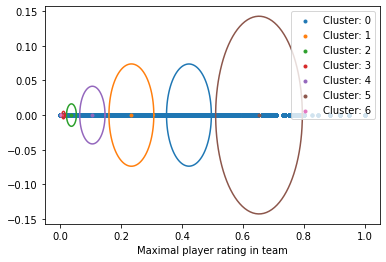

In [28]:
pis, mus, sigmas = em(x_train[:, 0].reshape((-1, 1)), 7)

In [32]:
def classify(point, pis, mus, sigmas, k):
    probabilites = np.array([ pis[i] * sp.stats.multivariate_normal.pdf(point, mean=mus[i], cov=sigmas[i]) for i in range(k) ])
    return np.argmax(probabilites)

In [33]:
classify(0.9, pis, mus, sigmas, 7)

5

In [34]:
team_results_test = []
for team_id, player_ids in team_player_ids_2020.items():
    team_player_ratings = []
    for i in range(len(player_ids)):
        if player_ids[i] in player_estimated_rating_increase_in_2020:
            team_player_ratings.append(player_estimated_rating_increase_in_2020[player_ids[i]])
    team_results_test.append(-np.sort(-np.array(team_player_ratings)))

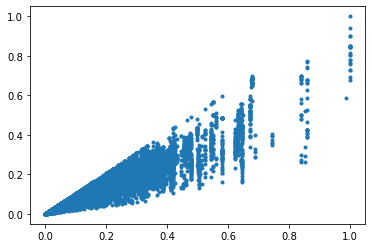

In [39]:
x_test = []
for team_result in team_results_test:
    x_test.append([team_result[0], np.mean(team_result)])
x_test = normalize(np.array(x_test))
plt.scatter(x_test[:, 0], x_test[:, 1], marker='.')